In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gym
from collections import namedtuple
import matplotlib.pyplot as plt

In [2]:
from train_Q import ModelQ_t
from memory import ReplayMemory, ReplayDataset
from model import Policy, weights_init

In [41]:
env = gym.make('MountainCar-v0')
print(env)

<TimeLimit<MountainCarEnv<MountainCar-v0>>>


In [65]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #позволяет перенести тензор на GPU, если он доступен в системе

In [50]:
BATCH_SIZE = 32
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
LR = 0.001
Transition = namedtuple('Transition',
                        ('state', 'next_s1', 'next_s2', 'next_s3', 'reward_1', 'reward_2', 'reward_3'))
memory = ReplayDataset(10000, Transition)
loss_fn = nn.MSELoss().type(torch.FloatTensor)
steps_done = 0

In [51]:
policy_net = Policy(env.observation_space.shape[0], 3)
weights_init(policy_net)
target_net = Policy(env.observation_space.shape[0], 3)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

Policy(
  (linear1): Linear(in_features=2, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=3, bias=True)
  (linear3): Linear(in_features=200, out_features=3, bias=True)
  (relu): ReLU()
)

In [52]:
optimizer = optim.RMSprop(policy_net.parameters(), lr = LR)
ModelQ = ModelQ_t(policy_net, target_net, env, GAMMA, steps_done, EPS_END, EPS_START, EPS_DECAY, 
                  memory, BATCH_SIZE, loss_fn, optimizer, TARGET_UPDATE)

In [53]:
num_episodes = 50
history_loss, history_reward = ModelQ.train(num_episodes, False)

tensor([-0.5519,  0.0069]) tensor([-1.]) tensor([-1.]) tensor([-1.])
tensor([-0.5145,  0.0082]) tensor([-1.]) tensor([-1.]) tensor([-1.])
tensor([-0.4601, -0.0016]) tensor([-1.]) tensor([-1.]) tensor([-1.])
tensor([-0.5154,  0.0035]) tensor([-1.]) tensor([-1.]) tensor([-1.])
tensor([-0.5479, -0.0008]) tensor([-1.]) tensor([-1.]) tensor([-1.])
tensor([-5.2141e-01, -3.6395e-04]) tensor([-1.]) tensor([-1.]) tensor([-1.])
tensor([-0.4978,  0.0034]) tensor([-1.]) tensor([-1.]) tensor([-1.])
tensor([-0.6028, -0.0015]) tensor([-1.]) tensor([-1.]) tensor([-1.])
tensor([-0.4714,  0.0045]) tensor([-1.]) tensor([-1.]) tensor([-1.])
tensor([-0.4860,  0.0005]) tensor([-1.]) tensor([-1.]) tensor([-1.])
tensor([-0.4738,  0.0036]) tensor([-1.]) tensor([-1.]) tensor([-1.])
tensor([-0.5745,  0.0013]) tensor([-1.]) tensor([-1.]) tensor([-1.])
tensor([-0.4701,  0.0020]) tensor([-1.]) tensor([-1.]) tensor([-1.])
tensor([-0.5058,  0.0022]) tensor([-1.]) tensor([-1.]) tensor([-1.])
tensor([-0.5184, -0.0014])

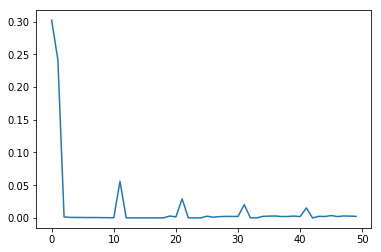

In [54]:
plt.plot(history_loss)

In [55]:
history_loss[3], history_loss[45:50]

(0.000827752157679892,
 [0.003624494963231781,
  0.0020850594053233697,
  0.0029920687596313657,
  0.0027770451753847784,
  0.002389864160537814])

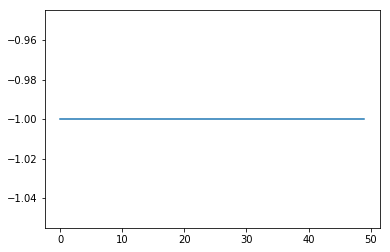

In [56]:
plt.plot(history_reward)

In [75]:
ModelQ.test(10, True)

tensor([0.5088, 0.0451]) tensor([100.])
tensor([0.5018, 0.0124]) tensor([100.])
tensor([0.5424, 0.0469]) tensor([100.])
tensor([0.5173, 0.0229]) tensor([100.])
tensor([0.5248, 0.0445]) tensor([100.])
tensor([0.5206, 0.0478]) tensor([100.])
tensor([0.5222, 0.0436]) tensor([100.])
tensor([0.5064, 0.0289]) tensor([100.])
tensor([0.5051, 0.0474]) tensor([100.])
tensor([0.5206, 0.0469]) tensor([100.])
100.0
Complete


In [71]:
from gym.wrappers import Monitor
import glob
from torch.distributions import Categorical, Normal
from pyvirtualdisplay import Display
import io
import base64
from IPython.display import clear_output, HTML
from IPython import display as ipythondisplay
%matplotlib inline
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1029'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1029'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [59]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [79]:
def agent_viz(env="MountainCar-v0", agent=None):
    """Visualizes agent play in the given environment.
    
    Args:
        env: The environment for agent to play in. Defaults to CartPole-v0.
        agent: The agent to play with. Defaults to None - 
            in this case random agent is used.

    Returns:
        Nothing is returned. Visualization is created and can be showed
            with show_video() function.
    """
    env = wrap_env(gym.make(env))
    observation = env.reset()
    while True:
        env.render() 
        if agent:
            with torch.no_grad():
                probs = agent(torch.FloatTensor(observation).to(device))
                action = torch.argmax(probs).item()
        else:
            action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            break
            
    env.close()

In [80]:
agent_viz(agent = ModelQ.policy_net)
show_video()